In [172]:
%load_ext autoreload
%autoreload 2
import os
import random

import hydra
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataloader import ARMA
from dataloader import ElectricDevices
from hydra.experimental import compose
from hydra.experimental import initialize_config_dir
from interpretability import get_hist
from interpretability import global_interpretability
from interpretability import input_max_neuron
from interpretability import neuron_max_class
from interpretability import shapley_bottleneck_vs_class
from interpretability import shapley_bottleneck_vs_output
from interpretability import shapley_input_vs_bottleneck
from interpretability import shapley_input_vs_class
from interpretability import shapley_input_vs_output
from models.CAE import CAE
from train import Trainer
from utils import accuracy
from utils import data_bottleneck_exploration
from utils import data_input_exploration
from utils import get_predictions
from utils import observation_reconstruction
from utils import reconstruction

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

In [173]:
with initialize_config_dir(config_dir=os.path.abspath("configs")):
    cfg = compose(config_name="config")

#dl = ElectricDevices()
dl = ARMA(1)
data_train, data_valid, data_test = dl()

X_train, y_train = data_train[:, :, :-1], data_train[:, :, -1]
X_valid, y_valid = data_valid[:, :, :-1], data_valid[:, :, -1]
X_test, y_test = data_test[:, :, :-1], data_test[:, :, -1]

In [174]:
model = CAE(cfg.model, num_classes=cfg.model.num_classes)

provement: 12

EPOCH 1800 train loss: 0.640404462814331, valid loss: 0.6533442497253418
epochs without improvement: 0

EPOCH 1810 train loss: 0.6404627680778503, valid loss: 0.653381073474884
epochs without improvement: 6

EPOCH 1820 train loss: 0.6404277086257935, valid loss: 0.6533737897872924
epochs without improvement: 3

EPOCH 1830 train loss: 0.6404935121536255, valid loss: 0.6532617092132569
epochs without improvement: 0

EPOCH 1840 train loss: 0.6402688980102539, valid loss: 0.6532509207725525
epochs without improvement: 0

EPOCH 1850 train loss: 0.6402230024337768, valid loss: 0.6531818270683288
epochs without improvement: 0

EPOCH 1860 train loss: 0.640310525894165, valid loss: 0.6532828092575074
epochs without improvement: 10

EPOCH 1870 train loss: 0.6402533411979675, valid loss: 0.6532201766967773
epochs without improvement: 20

EPOCH 1880 train loss: 0.6400790810585022, valid loss: 0.6532487273216248
epochs without improvement: 30

Training Finished in 393.2542769908905s


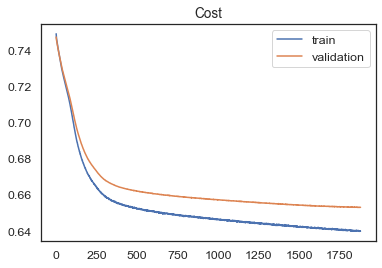

In [175]:
trainer = Trainer(cfg.train)
train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

In [176]:
# torch.save(model.state_dict(), "../weights/mod.pth")
# model.load_state_dict(torch.load("../weights/mod.pth"))

Predict testing data

In [177]:
 X_testp, y_testp = get_predictions(model, X_test)

# Evaluate

## Reconstruction

In [183]:
reconstruction(X_test, X_testp)

Distance Correlation avg and std: 0.7076624486439109 0.06387648340991167
NRMSE: 0.13840153813362122



## Reconstruction of individual observations

In [189]:
# SELECTED = [3279, 1156, 7419, 5046, 3323, 6485, 5497]

SELECTED = [
    np.random.choice([i for i, x in enumerate(y_test) if int(x) == j])
    for j in range(1)
]

observation_reconstruction(SELECTED, X_test, X_testp, y_test, y_testp)

## Accuracy

In [180]:
accuracy(y_test, y_testp)

Accuracy: 1.0


# Data Exploration

In [181]:
data_input_exploration(X_train)

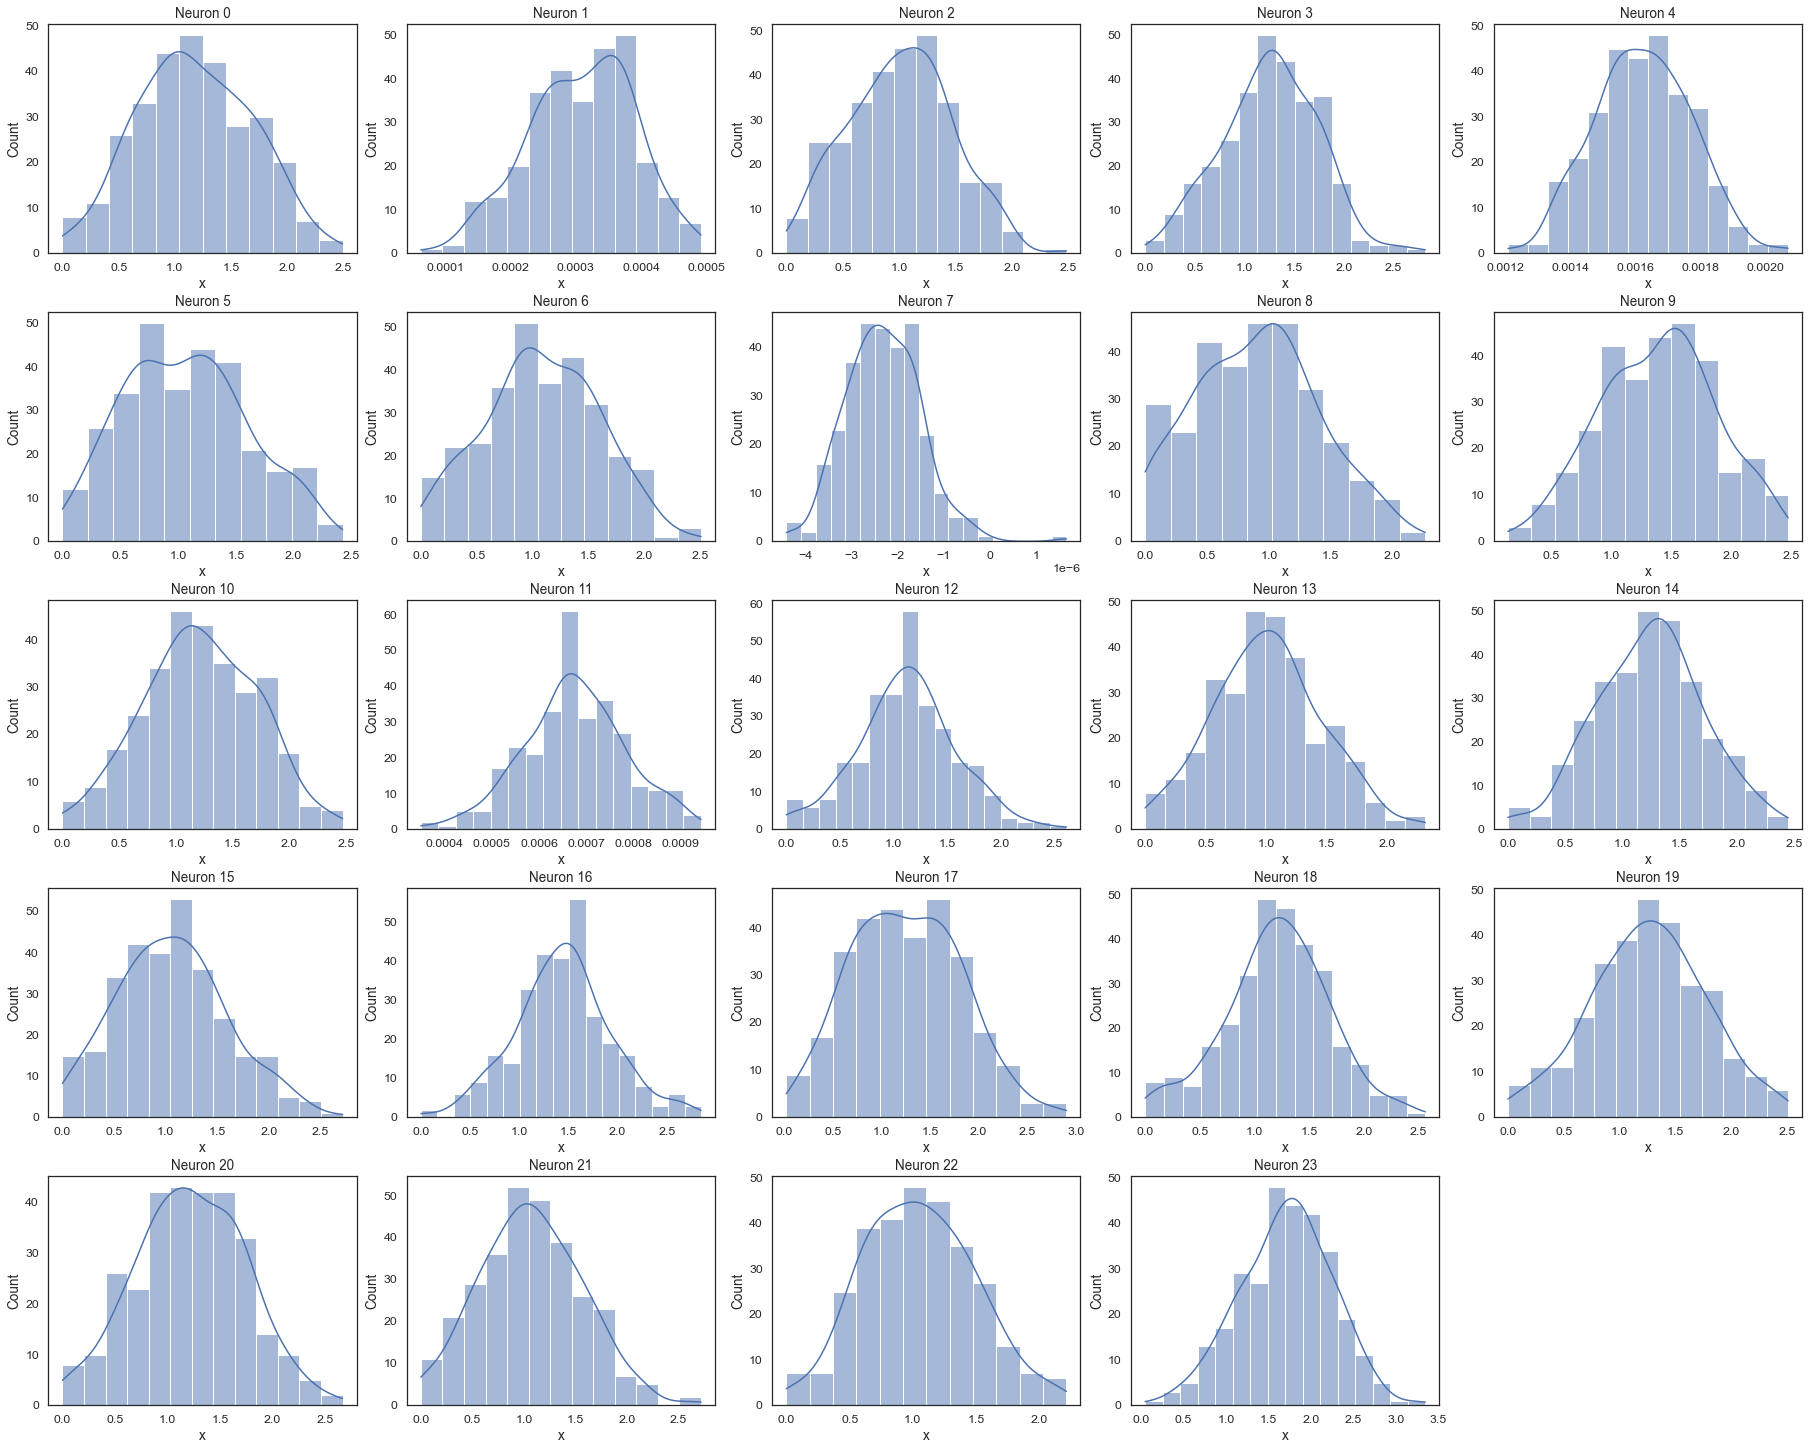

In [182]:
data_bottleneck_exploration(model, X_train)

# Interpretability

In [188]:
global_interpretability(model)

In [185]:
hist_input = [get_hist(X_train[:, 0, i]) for i in range(cfg.model.length)]
aux = model.encoder(X_train, False).detach().numpy()
hist_bn = [get_hist(aux[:, i]) for i in range(cfg.model.bottleneck_nn)]

In [186]:
shapley_input_vs_output(model, SELECTED, X_test, hist_input)

0 

KeyboardInterrupt: 

In [ ]:
shapley_bottleneck_vs_output(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_bottleneck(model, SELECTED, X_test, hist_input)

In [ ]:
shapley_bottleneck_vs_class(model, SELECTED, X_test, hist_bn)

In [ ]:
shapley_input_vs_class(model, SELECTED, X_test, hist_input)

# Feature Visualization

In [40]:
input_max_neuron(model)

In [ ]:
neuron_max_class(model)